In [1]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d
import matplotlib
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'font.size': 16})

In [2]:
#Load Data
td = cf.gen_and_load(10**5,10**3)
#Hold Out Validation
train_x, train_y = td[0]
val_x, val_y = td[1]

In [3]:
#Adam Optimiser
opt = keras.optimizers.Adam( amsgrad= True)

In [5]:
## Function Creates multiple Identical networks while varying batch size.
## Returns numpy array of Batch sizes 
## Returns numpy array of min MAPE of size len(batch_size),repeats
def batch_size_tester(start,step,no_items,repeats = 5,section = None):
    
    batch_sizes = [start+step*j for j in range(no_items)]
    is_last_val_bool = np.zeros_like(batch_sizes)
    min_mape = np.zeros((len(batch_sizes),repeats))
    for i,batch_size in enumerate(batch_sizes):
        print('Batch Size ',batch_size)
        last_val_bool = 0
        for j in range(repeats):
            #train network get MAPE Histories
            mape_df = cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,[512,512], optimizer= opt, verbose= 1,batch_size = batch_size).history
            #Smooth Arrays
            val_mape_ar_smoothed = cf.exponetial_smoothing(np.array(mape_df['val_mean_absolute_percentage_error']),0.4)
            loss_ar_smoothed = cf.exponetial_smoothing(np.array(mape_df['loss']),0.4)
            min_mape[i,j] = np.min(val_mape_ar_smoothed)
            #convergance test 
            if cf.neg_grad_tester(val_mape_ar_smoothed,loss_ar_smoothed):
                last_val_bool +=1
                print('Negative Grad Identified')
            else:
                pass
            tf.keras.backend.clear_session()  
                
        if last_val_bool >= 2:
            is_last_val_bool[i] = 1
        else:
            is_last_val_bool[i] = 0
    return min_mape, batch_sizes, last_val_bool

In [8]:
min_mape, batch_sizes , last_val_bool = batch_size_tester(4,20,20, repeats= 10)

Batch Size  4


2022-02-17 19:11:11.150890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 19:11:11.155504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 19:11:11.155756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 19:11:11.156479: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/30
24750/24750 [==============================] - 23s 909us/step - loss: 35.9861 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 35.9861 - val_loss: 11.7047 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 11.7047
Epoch 2/30
24750/24750 [==============================] - 22s 891us/step - loss: 11.8067 - mean_absolute_error: 0.0142 - mean_absolute_percentage_error: 11.8067 - val_loss: 9.8023 - val_mean_absolute_error: 0.0120 - val_mean_absolute_percentage_error: 9.8023
Epoch 3/30
10881/24750 [============>.................] - ETA: 12s - loss: 10.4300 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 10.4300

KeyboardInterrupt: 

In [4]:

##For very low batch sizes some networks dont converge
##This removes them, they are set to the mean plus one std some kind of average bad point
def clean_min_mape(min_mape):
    orig_min = min_mape.copy()
    mean_min_mape = np.mean(min_mape,axis =1 )
    mean_min_mape_array = (np.ones_like(min_mape).transpose()*mean_min_mape).transpose()
    std = np.std(min_mape,axis = 1)
    mean_plus_1_sigma = mean_min_mape+std
    mean_plus_1_sigma_array = (np.ones_like(min_mape).transpose()*mean_plus_1_sigma).transpose()
    #print(mean_plus_1_sigma_array)
    index = np.where(min_mape> mean_plus_1_sigma_array)
    min_mape[index] = mean_min_mape_array[index]

    return min_mape
cleaned_min_mape = clean_min_mape(min_mape)
#print(clean_mean)
clean_mean = np.mean(cleaned_min_mape,axis=1)
clean_ste = np.std(cleaned_min_mape,axis = 1)/10**0.5
print(min_mape[0,:])

[4.77797675 4.74349409 4.87811918 5.02811595 5.02811595 4.70297632
 4.60544568 5.02811595 5.02811595 4.95607957]


In [2]:
#print(last_val_bool)
#Calculation of plotting quantities
#np.savetxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/batch_size.csv',min_mape,delimiter= ',')
#np.savetxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/batch_size_bool.csv',last_val_bool,delimiter= ',')
min_mape = np.loadtxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Hyperparam_Testing/Testing_Notebooks/Testing_Data/bs/batch_size_18_02.csv',delimiter= ',')
#last_val_bool = np.loadtxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Hyperparam_Testing/Testing_Notebooks/Testing_Data/bs/batch_size_bool_18_02.csv',delimiter= ',')

batch_sizes = [4+20*i for i in range(20)]
last_val_bool = np.zeros_like(min_mape)
mean_min_mape = np.mean(min_mape,axis= 1)
std_min_mape = np.std(min_mape,axis= 1)
ste = std_min_mape/10**0.5


In [3]:
std_min_mape

array([0.1096097 , 0.12558498, 0.14331439, 0.11902348, 0.17935261,
       0.08066329, 0.15499642, 0.27033035, 0.18850312, 0.18324407,
       0.16799659, 0.23034647, 0.17465738, 0.18407925, 0.18008486,
       0.26029277, 0.39014731, 0.30162722, 0.37595413, 0.43028813])

/tmp/ipykernel_528203/503830528.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


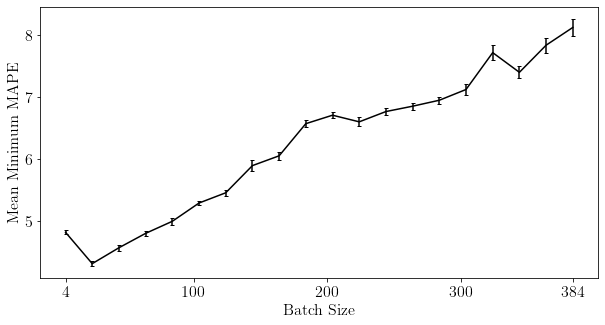

In [14]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['text.usetex'] = True
#plotting
fig, ax = plt.subplots(1,1, figsize= (10,5))
#ax = fig.add_axes((0,0,1,1))
ax.errorbar(batch_sizes,mean_min_mape,ste,color = 'black',capsize= 2)
#ax.plot(4,clean_mean[0],marker = 'x', linestyle = '', c = 'red')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Mean Minimum MAPE')
ticks = [4,100,200,300,384,]
ax.set_xticklabels(ticks)
ax.set_xticks(ticks)


In [15]:
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/batch_size_20_2_22.png',dpi = 300, transparent= False)